In [1]:
from am4pa.linnea import LinneaConfig
from va4algs import DataExtractorLinnea
from va4algs import DataAnalyzer3Way
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

In [3]:
linnea_config = LinneaConfig("GLS",12)
linnea_config.set_local_directory("linnea/GLS/")
linnea_config.setup_backend_details(server="login18-1.hpc.itc.rwth-aachen.de",
                                   uname = "as641651",
                                   init_script="~/.analyzer",
                                   backend_dir="~/PhD/va4algs-exps/GLS/")
linnea_config.connect_backend()

In [9]:
de = DataExtractorLinnea(linnea_config)
op_sizes = [["1000", "200"], ["1000", "300"], ["1000", "100"], ["1000", "150"], ["100", "1000"] ]
de.add_operands(op_sizes)
de.generate_variants()

de.reset_measured()
de.check_measured(4)
de.filter_on_flops(0.1)
# de.measure_variants(reps=5, run_id=4)
#de.prepare_data_for_analysis(clear=False)

scp as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/GLS/experiments/100_1000/run_times.csv linnea/GLS/cluster-data/100_1000
Command '['scp', 'as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/GLS/experiments/100_1000/run_times.csv', 'linnea/GLS/cluster-data/100_1000']' returned non-zero exit status 1.


scp: /home/as641651/PhD/va4algs-exps/GLS/experiments/100_1000/run_times.csv: No such file or directory


In [184]:
de.q_min = 25
de.q_max = 75
# de.q_min = 0
# de.q_max = 0
de.bRankReliable = False
de.prepare_data_for_analysis(clear=False)

In [185]:
da = DataAnalyzer3Way(de.data_kernels, de.data_relations, de.data_ext)

In [186]:
da.discover_kernel_rules()

,index,kernel,case:rel-flops,-1,0,1,total,good (%),bad (%),selection score
0,1,LAPACK.syev,0.006742,3,0,0,3,0.0,1.0,0.0
1,4,qr,0.004494,4,0,0,4,0.0,1.0,0.0
2,6,transpose,0.000000,5,0,0,5,0.0,1.0,0.0


In [187]:
da.discover_relations_rules()

class,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,7,gemm,LAPACK.potrf,0,0,3,3,1.0,0.0,1.0
1,15,gemv,gemv,7,0,0,7,0.0,1.0,0.0


In [188]:
da.discover_kernel_anomalies()

,kernel,case:rel-flops,-1,0,1,total,good (%),bad (%),selection score
2,gemm,0.022472,0,1,2,3,0.67,0.0,1.0


In [189]:
kernel = 'LAPACK.syev'
ops = da.find_operands_on_cl(-1, kernel)
ops

['1000_200', '1000_100', '1000_150']

In [190]:
#de.data_vcs[ops[-1]].get_dfg_minus_best_worst()

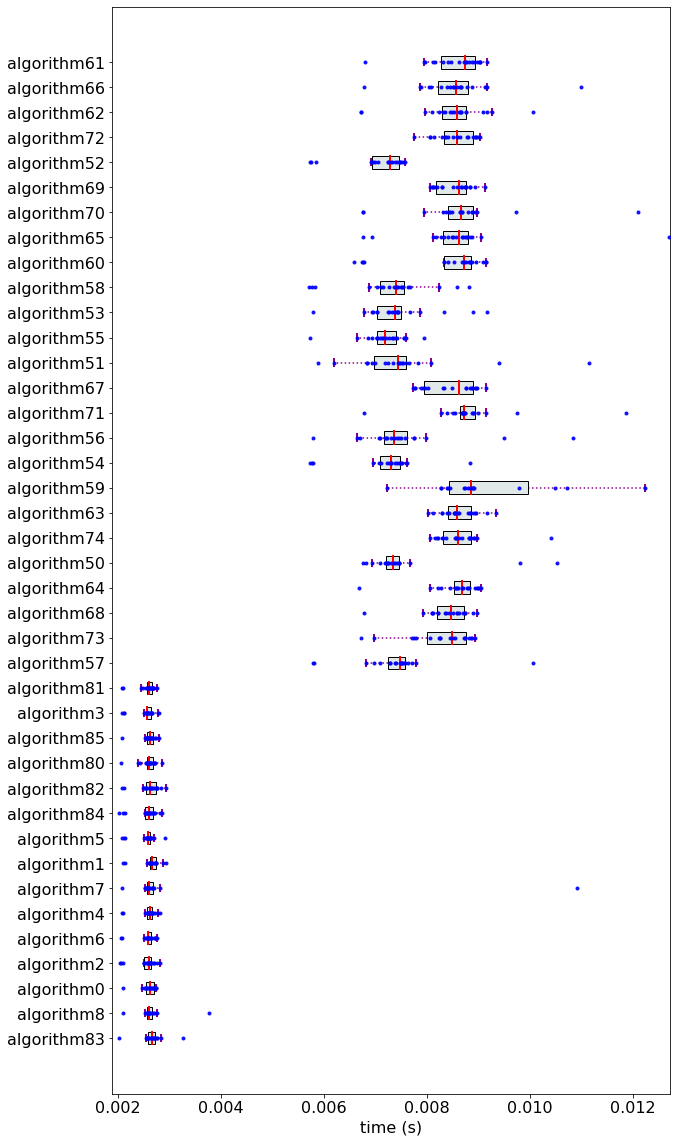

In [191]:
a1 = de.get_algs_with_kernel(ops[-1], kernel)
a2 = de.get_best_algs(ops[-1])
fig = de.visualize_box_plots(ops[-1], a2+a1, scale=0.5)

['1000_200', '1000_300', '1000_100', '1000_150']


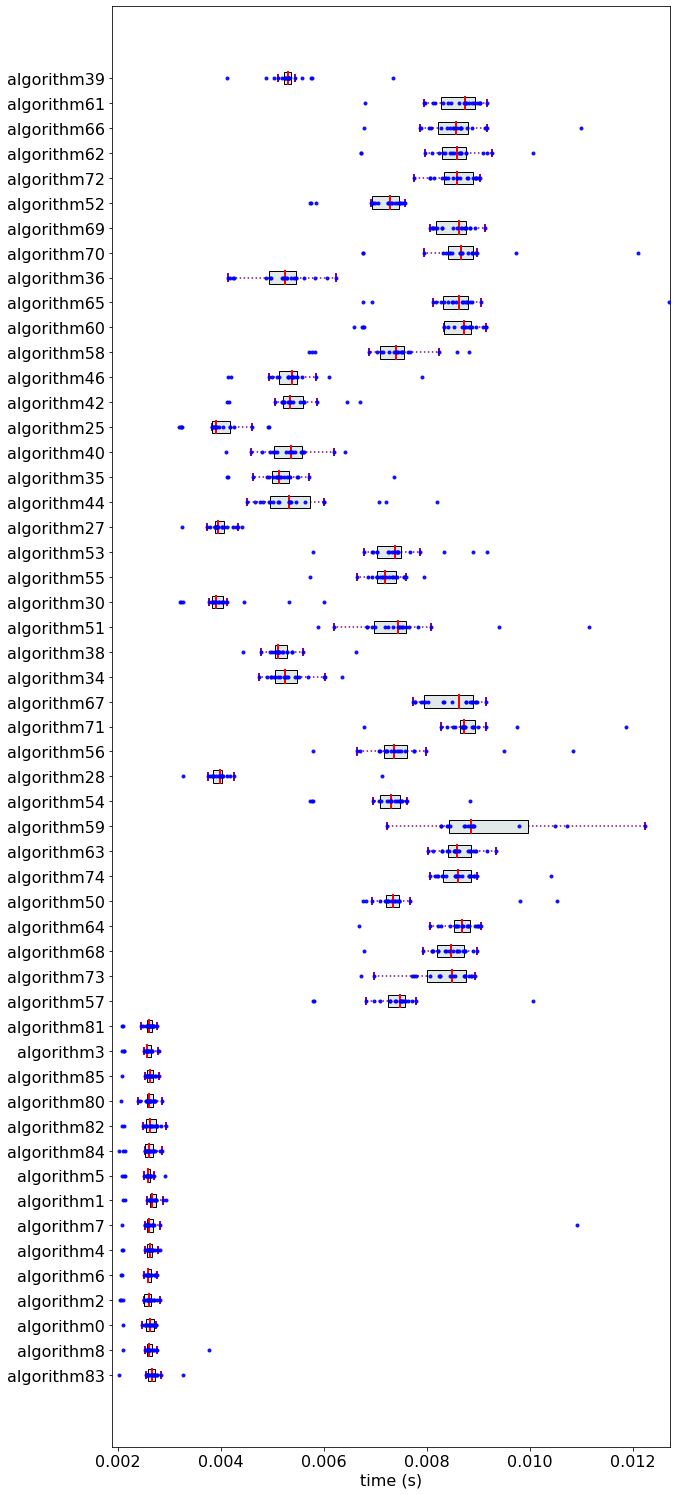

In [192]:
# kernelA = "trsm"
# kernelB = "trsm"
kernelA = "gemv"
kernelB = "gemv"
ops = da.find_operands_on_cl(-1, kernelA, kernelB)
print(ops)
a3 = de.get_algs_with_relation(ops[-1], kernelA, kernelB)
a2 = de.get_best_algs(ops[-1])
fig = de.visualize_box_plots(ops[-1], a2+a3, scale=0.5)

In [193]:
dy = da.filter_relations_not_in_rules()
dy

class,level_0,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,2,3,LAPACK.potrf,trsm,2,7,0,9,0.00,0.22,0.0
1,20,34,trsm,trsv,2,6,0,8,0.00,0.25,0.0
2,10,19,gemv,trsv,4,5,0,9,0.00,0.44,0.0
3,19,33,trsm,trsm,1,1,0,2,0.00,0.50,0.0
4,17,31,trsm,gemv,2,6,0,8,0.00,0.25,0.0
5,26,42,trsv,trsm,2,6,0,8,0.00,0.25,0.0
6,5,11,gemv,@@endnode,3,1,0,4,0.00,0.75,0.0
7,27,43,trsv,trsv,4,6,0,10,0.00,0.40,0.0
8,4,9,gemm,gemv,0,1,2,3,0.67,0.00,1.0
9,16,30,trsm,gemm,0,1,2,3,0.67,0.00,1.0


In [194]:
da.train_dtree_classifiers(dy['kernelA'].to_list(),dy['kernelB'].to_list()) 

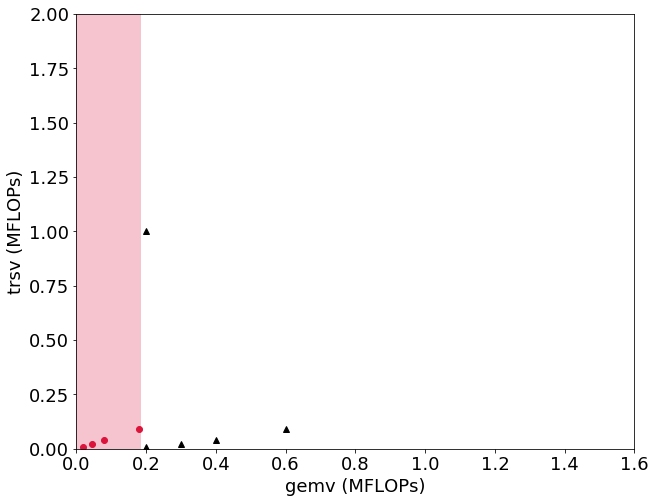

In [195]:
kernelA = 'gemv'
kernelB = 'trsv'
fig = da.get_regions_plot(kernelA, kernelB)

In [196]:
da.discover_impurities()

,kernelA,flopsA,kernelB,flopsB,class,impurity
124,trsm,10000000.0,trsm,10000000.0,"[-1, 0]",0.50
188,trsv,1000000.0,trsv,1000000.0,"[-1, -1, -1, -1, 0]",0.32


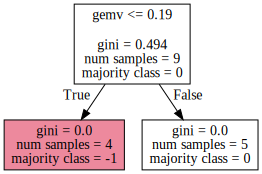

In [197]:
dtree = da.get_dtree(kernelA, kernelB)
dtree

['1000_200', '1000_300', '1000_100', '1000_150']


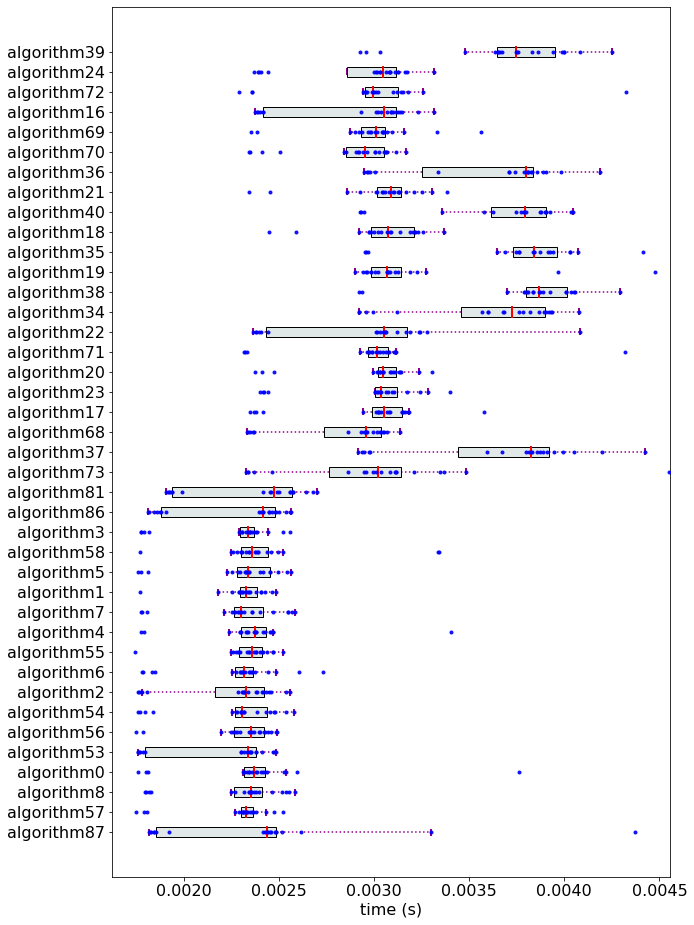

In [198]:
ops = da.find_operands_on_cl(-1, kernelA, kernelB)
print(ops)
op_str = '1000_100'
a5 = de.get_algs_with_relation_flops(op_str, kernelA, '<', 0.2, kernelB, '<', 0.2)
#a5 = de.get_algs_with_relation_flops(op_str, kernelA, '<', 0.5, kernelB, '<', 0.2)
a1 = de.get_best_algs(op_str)
a1_ = [a for a in a1 if a not in a5]
#print(a1_)
fig = de.visualize_box_plots(op_str, a1_+a5, scale=0.4)